### Import Libraries


In [1]:
import numpy as np

# Import pandas
import pandas as pd

# Core scverse libraries
import scanpy as sc
import anndata as ad

# Gerard's libraries
from src.uniprot_client import UniprotClient

# Data retrieval
import pooch

# import seaborn
import seaborn as sns

import matplotlib.pyplot as plt


/Users/gerardfont/Documents/Gerard/Master_BiomedicalDataScience/00_Master_THESIS/code/pyMSpro/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


___
### Config

In [2]:
TRANSLATE_PROTEIN_ID = True

---
### Load the Data

In [3]:
# Load the data (Scanpy assumes that your columns are genes and your rows are cells)
data_src = "./data/processed/2021_Leduc/prot_proc.csv"
data = pd.read_csv(data_src, delimiter=",")

# Transpose the data
data = data.T

# Keep the first row as the column names
proteins = data.iloc[0]

# Remove the first column
data = data.iloc[1:]

# Create an AnnData object with the data
adata = ad.AnnData(data.astype(np.float32))

proteins = proteins.to_numpy()
adata.var['proteins'] = proteins

print(adata)


AnnData object with n_obs × n_vars = 163 × 1647
    var: 'proteins'


/Users/gerardfont/Documents/Gerard/Master_BiomedicalDataScience/00_Master_THESIS/code/pyMSpro/venv/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
# Load the anno.csv file with the cell type annotations
anno_src = "./data/processed/2021_Leduc/anno.csv"
anno = pd.read_csv(anno_src, delimiter=",")

# Transpose the data
anno = anno.T

# Print column names
celltypes = anno.loc[:, 1].values

# Remove the first element
celltypes = celltypes[1:]

# Create a new obs in the AnnData object with the cell type annotations 
adata.obs['celltype'] = celltypes



---
### Convert Protein ID to Gene names

In [5]:
if TRANSLATE_PROTEIN_ID:
    # Convert proteins to gene names
    unipcl = UniprotClient()

    gene_names = unipcl.batch_translate_protein_ids(adata.var['proteins'])
    adata.var['proteins'] = [gene_names.get(i, i) for i in adata.var['proteins']]
    print(adata.var['proteins'])


0         NUDT4B (A0A024RBG1)
1       TRBV12-5 (A0A1B0GX78)
2              IFT56 (A0AVF1)
3           ARHGAP10 (A1A4S6)
4              LAMB4 (A4D0S4)
                ...          
1642          ADGRG1 (Q9Y653)
1643         EMILIN1 (Q9Y6C2)
1644         ARFGEF1 (Q9Y6D6)
1645           DDX49 (Q9Y6V7)
1646          DUSP10 (Q9Y6W6)
Name: proteins, Length: 1647, dtype: object


---
### PCA & UMAP



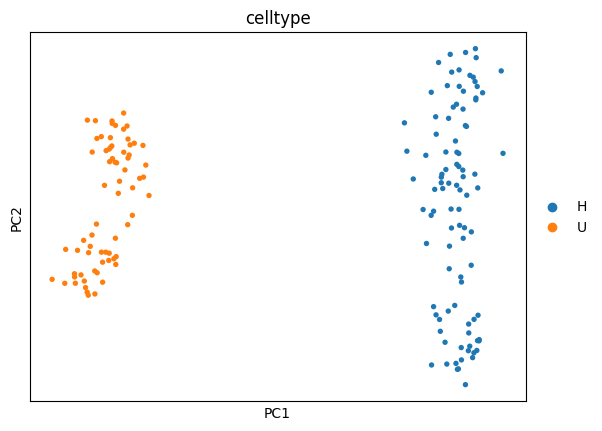

In [6]:
# PCA by cell type
sc.tl.pca(adata)
sc.pl.pca(adata, color='celltype', size=60)


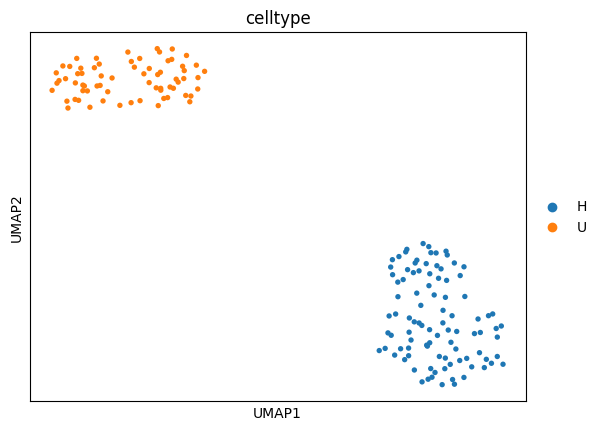

In [7]:
# UMAP by cell type
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='celltype', size=60)

---

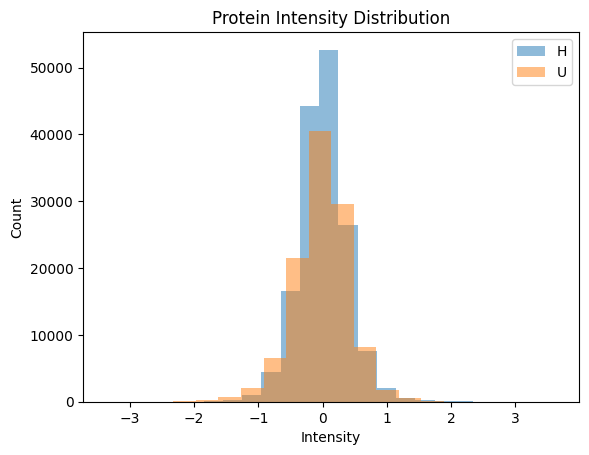

In [8]:
num_bins = 20

for celltype in adata.obs['celltype'].unique():
    plt.hist(adata[adata.obs['celltype'] == celltype].X.flatten(), bins=num_bins, alpha=0.5, label=celltype)

plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title('Protein Intensity Distribution')

plt.legend()
plt.show()


In [9]:
print(adata)


AnnData object with n_obs × n_vars = 163 × 1647
    obs: 'celltype'
    var: 'proteins'
    uns: 'pca', 'celltype_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


/Users/gerardfont/Documents/Gerard/Master_BiomedicalDataScience/00_Master_THESIS/code/pyMSpro/venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/gerardfont/Documents/Gerard/Master_BiomedicalDataScience/00_Master_THESIS/code/pyMSpro/venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


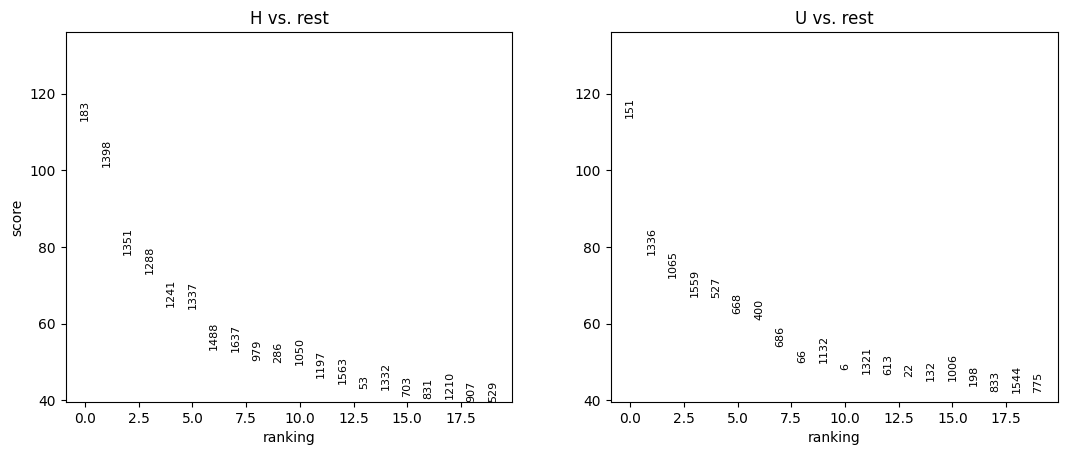

In [23]:
# Differential expression analysis
sc.tl.rank_genes_groups(adata, groupby='celltype', method='t-test')
sc.pl.rank_genes_groups(adata)

In [22]:
print(result)

{'params': {'groupby': 'celltype', 'reference': 'rest', 'method': 't-test', 'use_raw': False, 'layer': None, 'corr_method': 'benjamini-hochberg'}, 'names': rec.array([('183', '151'), ('1398', '1336'), ('1351', '1065'), ...,
           ('1065', '1351'), ('1336', '1398'), ('151', '183')],
          dtype=[('H', 'O'), ('U', 'O')]), 'scores': rec.array([( 112.79028 ,  113.77344 ), ( 100.939415,   77.876076),
           (  78.073586,   71.907326), ..., ( -71.907326,  -78.073586),
           ( -77.876076, -100.939415), (-113.77344 , -112.79028 )],
          dtype=[('H', '<f4'), ('U', '<f4')]), 'pvals': rec.array([(1.10674441e-139, 2.21126842e-113),
           (2.34515361e-138, 3.63334372e-112),
           (9.72656594e-129, 4.93586788e-124), ...,
           (4.93586788e-124, 9.72656594e-129),
           (3.63334372e-112, 2.34515361e-138),
           (2.21126842e-113, 1.10674441e-139)],
          dtype=[('H', '<f8'), ('U', '<f8')]), 'pvals_adj': rec.array([(1.82280804e-136, 5.20279870e-111),
 

In [18]:

# Extract results
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
group1 = groups[0]
group2 = groups[1]

# Create DataFrame for easier handling
df = pd.DataFrame({
    'protein': result['names'][group1],
    f'logFC_{group1}': result['logfoldchanges'][group1],
    f'logFC_{group2}': result['logfoldchanges'][group2],
    f'pval_{group1}': result['pvals'][group1],
    f'pval_{group2}': result['pvals'][group2],
    f'pval_adj_{group1}': result['pvals_adj'][group1],
    f'pval_adj_{group2}': result['pvals_adj'][group2],
    f'score_{group1}': result['scores'][group1],
    f'score_{group2}': result['scores'][group2]
})

# Filter out entries with NaN log fold changes
df_filtered = df.dropna(subset=[f'logFC_{group1}', f'logFC_{group2}'])

# Print the filtered DataFrame
print(df_filtered.head())


Empty DataFrame
Columns: [protein, logFC_H, logFC_U, pval_H, pval_U, pval_adj_H, pval_adj_U, score_H, score_U]
Index: []


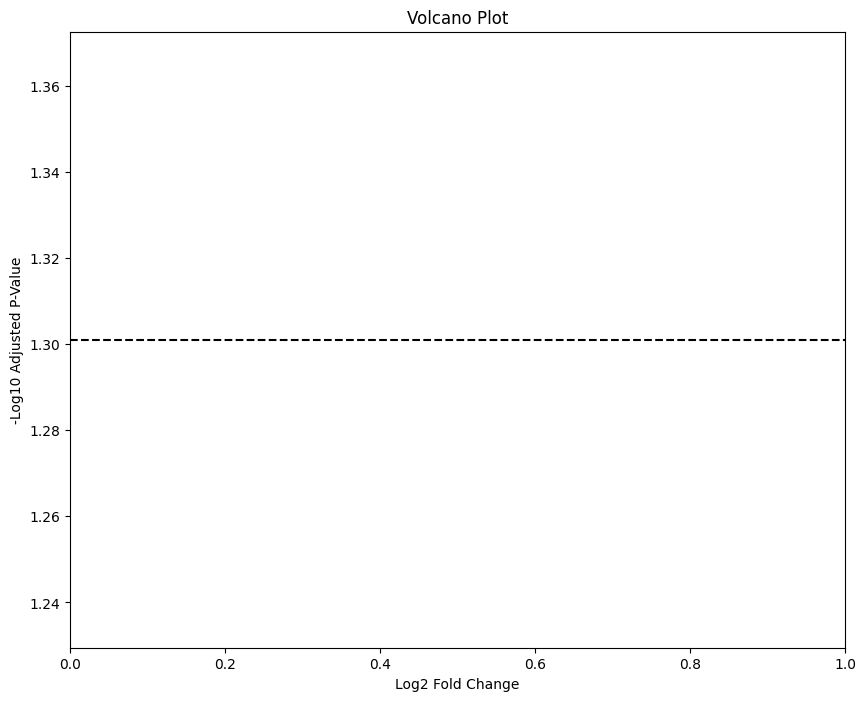

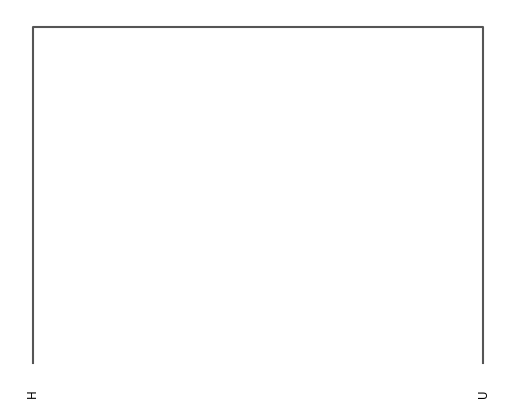

<Axes: >

In [12]:

# Extract results for volcano plot
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pvals_adj = result['pvals_adj'][groups[0]]
logfoldchanges = result['logfoldchanges'][groups[0]]
gene_names = result['names'][groups[0]]

# Create DataFrame for plotting
volcano_df = pd.DataFrame({
    'protein': gene_names,
    'logFC': logfoldchanges,
    'p-adj': pvals_adj
})

# Volcano plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=volcano_df, x='logFC', y=-np.log10(volcano_df['p-adj']),
                hue=np.log10(volcano_df['p-adj']) < -np.log10(0.05), palette={True: 'red', False: 'grey'}, legend=None)
plt.axhline(-np.log10(0.05), linestyle='--', color='black')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-Value')
plt.title('Volcano Plot')
plt.show()

# Clustering and dendrogram
sc.tl.dendrogram(adata, groupby='celltype')
sc.pl.dendrogram(adata, groupby='celltype')

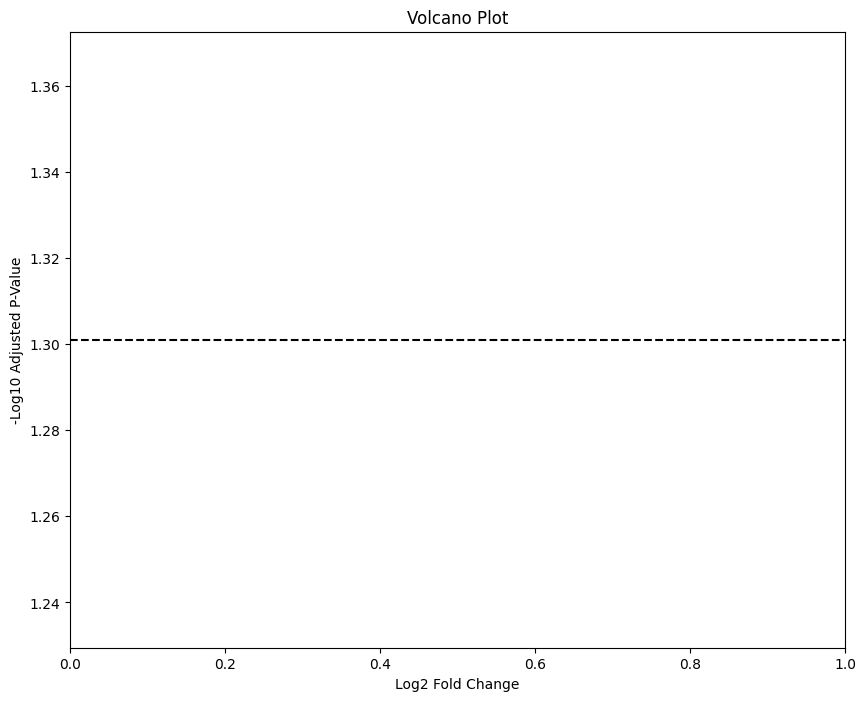

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

# Extract results
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pvals_adj = result['pvals_adj'][groups[0]]
logfoldchanges = result['logfoldchanges'][groups[0]]
gene_names = result['names'][groups[0]]

# Create DataFrame for plotting
volcano_df = pd.DataFrame({
    'protein': gene_names,
    'logFC': logfoldchanges,
    'p-adj': pvals_adj
})

# Volcano plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=volcano_df, x='logFC', y=-np.log10(volcano_df['p-adj']),
                hue=np.log10(volcano_df['p-adj']) < -np.log10(0.05), palette={True: 'red', False: 'grey'}, legend=None)
plt.axhline(-np.log10(0.05), linestyle='--', color='black')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-Value')
plt.title('Volcano Plot')
plt.show()

/Users/gerardfont/Documents/Gerard/Master_BiomedicalDataScience/00_Master_THESIS/code/pyMSpro/venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/gerardfont/Documents/Gerard/Master_BiomedicalDataScience/00_Master_THESIS/code/pyMSpro/venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


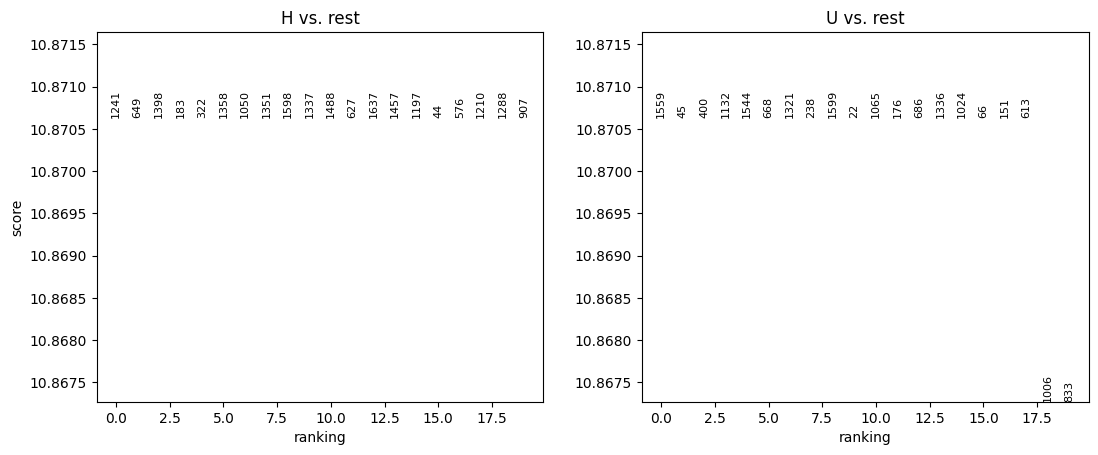

In [ ]:
# Differential expression analysis with optional sparse matrix conversion
#sc.tl.rank_genes_groups(adata, groupby='celltype', method='t-test')
sc.tl.rank_genes_groups(adata, 'celltype', method='wilcoxon')
# to visualize the results
sc.pl.rank_genes_groups(adata)

In [ ]:
# Perform differential expression analysis
sc.tl.rank_genes_groups(adata, groupby='celltype', method='t-test')

/Users/gerardfont/Documents/Gerard/Master_BiomedicalDataScience/00_Master_THESIS/code/pyMSpro/venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/gerardfont/Documents/Gerard/Master_BiomedicalDataScience/00_Master_THESIS/code/pyMSpro/venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


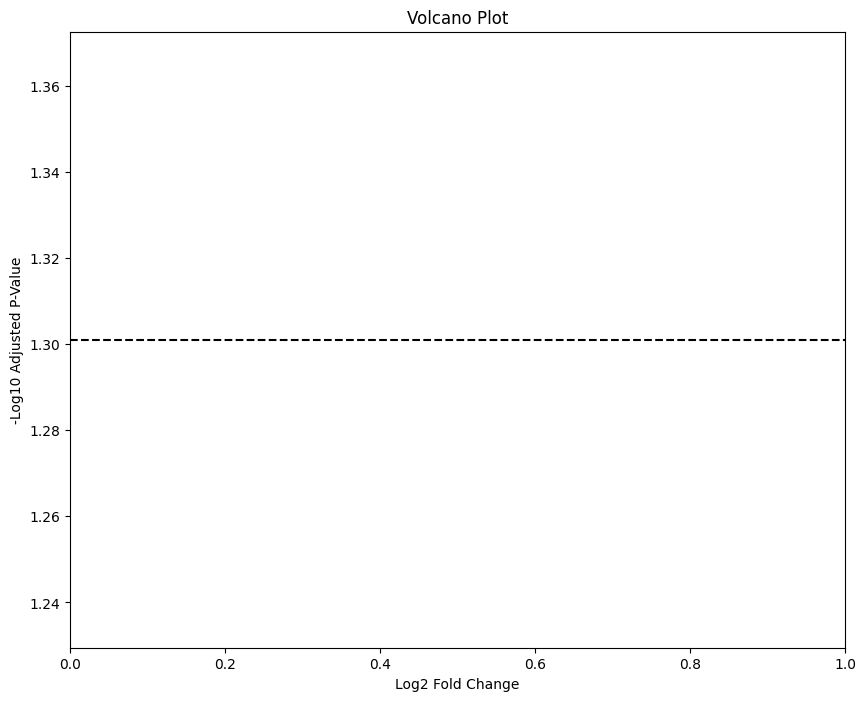

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract results
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pvals_adj = result['pvals_adj'][groups[0]]
logfoldchanges = result['logfoldchanges'][groups[0]]
gene_names = result['names'][groups[0]]

# Create DataFrame for plotting
volcano_df = pd.DataFrame({
    'protein': gene_names,
    'logFC': logfoldchanges,
    'p-adj': pvals_adj
})

# Volcano plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=volcano_df, x='logFC', y=-np.log10(volcano_df['p-adj']),
                hue=np.log10(volcano_df['p-adj']) < -np.log10(0.05), palette={True: 'red', False: 'grey'}, legend=None)
plt.axhline(-np.log10(0.05), linestyle='--', color='black')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-Value')
plt.title('Volcano Plot')
plt.show()


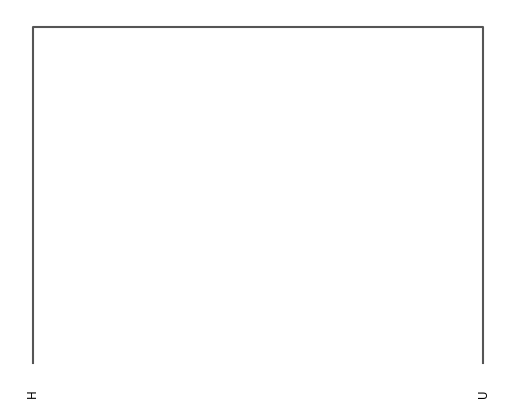

<Axes: >

In [ ]:
# Clustering
sc.tl.dendrogram(adata, groupby='celltype')

# Plot dendrogram
sc.pl.dendrogram(adata, groupby='celltype')
